# Twitter Sentiment Analysis / Clasiffication Models analysis

#### Add Sentiment Analysis and models description  

#### Data Description
The dataset being used is the <a href="https://www.kaggle.com/kazanova/sentiment140" target="_blank">sentiment140</a> dataset. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.

##### Data Details
It contains the following 6 fields: 
* **sentiment**: the polarity of the tweet (0 = negative, 4 = positive)
* **ids**: The id of the tweet (2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

#### Reference
* **Hands-on Machine Learning with Scikit-Learn & TensorFlow**

### Import necessary libraries

In [1]:
# DataFrame
import numpy as np
import pandas as pd
import re

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split

### Import Data

In [2]:
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df_encoding = 'latin-1'

In [3]:
df_raw = pd.read_csv('Data/training.1600000.processed.noemoticon.csv', names = columns, header= None, encoding= df_encoding)

### EDA

In [4]:
df_raw.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
target    1600000 non-null int64
ids       1600000 non-null int64
date      1600000 non-null object
flag      1600000 non-null object
user      1600000 non-null object
text      1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
print("Dataset size:", len(df_raw))

Dataset size: 1600000


**Let's look at one example of a negative and one example of positive tweet, to see what the data looks like:**

In [7]:
print(df_raw[df_raw['target'] == 0]['text'][1])

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!


In [8]:
print(df_raw[df_raw['target'] == 4]['text'][800001])

im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!


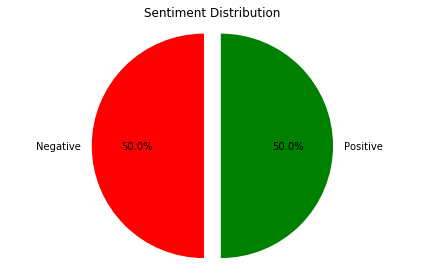

In [9]:
# sum the instances of males and females
negative = (df_raw['target'] == 0).sum()
positive = (df_raw['target'] == 4).sum()

# put them into a list called proportions
proportions = [negative, positive]

# Create a pie chart
plt.pie(
    # using proportions
    proportions,
    
    # with the labels being officer names
    labels = ['Negative', 'Positive'],
    
    # with no shadows
    shadow = False,
    
    # with colors
    colors = ['red','green'],
    
    # with one slide exploded out
    explode = (0.15 , 0),
    
    # with the start angle at 90%
    startangle = 90,
    
    # with the percent listed as a fraction
    autopct = '%1.1f%%'
    )

# View the plot drop above
plt.axis('equal')

# Set labels
plt.title("Sentiment Distribution")

# View the plot
plt.tight_layout()
plt.show()

### Data Cleaning

In [10]:
# Remove unnecessary columns
df = df_raw[['target', 'text']]

# Replace a value for positive tweets
df['target'].replace(to_replace = 4, value =1, inplace=True)

C:\Users\ThinkPad\Anaconda3\lib\site-packages\pandas\core\generic.py:5886: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [11]:
df['target'].value_counts()

1    800000
0    800000
Name: target, dtype: int64

#### Splitting the data

**Before we learn too much about the data, we will split it into a training set and a test set.**

In [12]:
text, sentiment = list(df['text']), list(df['target'])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(text, sentiment, test_size=0.2, random_state=42)

#### Preprocess Text

In [18]:
# Import nltk and define other data cleaning parameters

import nltk
import nltk
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
stopwords = nltk.corpus.stopwords.words('english')
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'

# Define WordLemmatizer
# wordLemmatizer = WordNetLemmatizer()
# for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
#     print(word, "=>", wordLemmatizer.lemmatize(word))

# Define stemmer
stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
    print(word, "=>", stemmer.stem(word))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ThinkPad\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


### Tweet to word count transformer

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter

class TweetToWordCounterTransformer(BaseEstimator, TransformerMixin):
    """Takes in dataframe/raw tweets and converts them to word counters"""
    def __init__(self, lower_case=True, replace_url=True, replace_username=True, remove_punctuation=True, replace_numbers=True, remove_stopwords=True, stemming=True):
        self.lower_case = lower_case
        self.replace_url = replace_url
        self.replace_username = replace_username
        self.remove_punctuation = remove_punctuation
        self.replace_numbers = replace_numbers
        self.remove_stopwords = remove_stopwords
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for tweet in X:
            if self.lower_case:
                tweet = tweet.lower()
            if self.replace_url:
                tweet = re.sub(urlPattern,' URL',tweet)
            if self.replace_username:
                tweet = re.sub(userPattern,' USER', tweet)
            if self.replace_numbers:
                tweet = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', tweet)
            if self.remove_punctuation:
                tweet = re.sub(r'\W+', ' ', tweet, flags=re.M)
            if self.remove_stopwords:
                tweet=tweet.split()
                for word in list(tweet):
                    if word in stopwords:
                        tweet.remove(word)            
            word_counts = Counter(tweet)
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)               

In [20]:
# Test the TweetToWordCounterTransformer
X_few = X_train[:2]
X_few_wordcounts = TweetToWordCounterTransformer().fit_transform(X_few)
print(X_train[:2])
print(X_few_wordcounts)

["@jbtaylor WIth ya. &quot;I'd like a Palm Pre, Touchstone charger. ReadyNow? Yes, that sounds good. But is my beer ready now?'  #prelaunch", 'felt the earthquake this afternoon, it seems to be a , but  at the epicenter ']
[Counter({'user': 1, 'ya': 1, 'quot': 1, 'like': 1, 'palm': 1, 'pre': 1, 'touchston': 1, 'charger': 1, 'readynow': 1, 'ye': 1, 'sound': 1, 'good': 1, 'beer': 1, 'readi': 1, 'prelaunch': 1})
 Counter({'felt': 1, 'earthquak': 1, 'afternoon': 1, 'seem': 1, 'epicent': 1})]


### Word count to vector transformer

In [21]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    """Takes in dataframe / word counts, and converts that count to vectors"""
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        """Builds a vocabulary, an ordered list of the most common words"""
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        """Converts word counts to vectors."""
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [22]:
# Test the WordCounterToVectorTransformer
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors.toarray()

array([[5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [23]:
# Check the vocabulary content
vocab_transformer.vocabulary_

{'user': 1,
 'ya': 2,
 'quot': 3,
 'like': 4,
 'palm': 5,
 'pre': 6,
 'touchston': 7,
 'charger': 8,
 'readynow': 9,
 'ye': 10}

#### Transform the training dataset

In [24]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("tweet_to_wordcount", TweetToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)
X_test_transformed = preprocess_pipeline.transform(X_test)

# Create and Evaluate Models

In [25]:
# import models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# import model performance evaluation tools
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [26]:
# Define models
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42),
#     LinearSVC(),
    BernoulliNB(alpha=2),
    LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42),]

In [27]:
CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train_transformed, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [28]:
print(cv_df.groupby('model_name').accuracy.mean())

model_name
BernoulliNB               0.740083
LogisticRegression        0.750624
RandomForestClassifier    0.671791
Name: accuracy, dtype: float64


#### Best model

In [29]:
# Model fit
log_model = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
log_model.fit(X_train_transformed, y_train)
y_pred = log_model.predict(X_test_transformed)

print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.76      0.72      0.74    159494
          1       0.74      0.78      0.76    160506

avg / total       0.75      0.75      0.75    320000



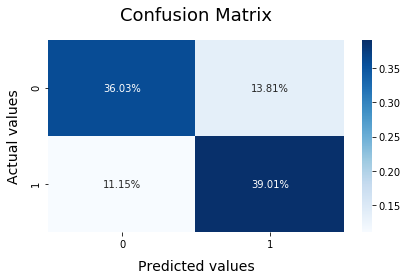

In [30]:
# Compute and plot the Confusion matrix
# import seaborn
import seaborn as sns

cf_matrix = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.tight_layout()